In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_palette('rainbow',8, 0.45)

In [295]:
files_path = 'Files'

In [65]:
rt_movies = pd.read_csv(os.path.join(files_path, "rt_movies.csv"), index_col=0)
rt_reviews = pd.read_csv(os.path.join(files_path, "rt_reviews.csv"), index_col=0)

In [66]:
rt_reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_year
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,2010
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",2010
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...,2010
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,2010
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,2010


## Amostragem e Lematização

In [7]:
import json
import requests
import re
import string
import langid
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

### Preparação dos Dados

In [5]:
# Reduzindo os dados para poder aplicar a lematização. Dados estratificados por filme e tipo de review. 
rt_reviews_strat = rt_reviews.groupby(['rotten_tomatoes_link','review_type'], 
                                      group_keys=False).apply(lambda x: x.sample(frac=0.4))

In [53]:
rt_reviews_strat.shape

(425384, 9)

In [164]:
rt_reviews_strat['review_type'].value_counts()

Fresh     272305
Rotten    153079
Name: review_type, dtype: int64

In [73]:
df = rt_reviews_strat[['review_content', 'review_type']]

In [177]:
def lang_idf(df):
    '''Checa o texto para ver se a lingua escrita é inglês, se não for retorna Falso.
    Args:
        df: dataframe object.
    Returns: 
        df: dataframe object com coluna indicando a língua.'''
    lang = []
    for text in df['review_content']:
        lang.append(langid.classify(text)[0])
    df['lang_idf'] = lang
    
    return df

In [70]:
def prepare_text(df):
    '''Lemmatiza o texto para passar pelo modelo.
    Args:
        df: dataframe object.
    Returns:
        df: dataframe object com o texto preparado.'''

    mov_end = []

    for index, item in enumerate(nlp.pipe(df['review_content'], n_process=6, batch_size=2000)):
        doc = nlp(item)
        lemmatized_sentence = " ".join([token.lemma_ for token in doc if not token.is_stop])
        mov_end.append(lemmatized_sentence)
        
    df['prepared_review_content'] = mov_end
    
    return df

In [284]:
rt_reviews_strat = lang_idf(rt_reviews_strat)

In [289]:
rt_reviews_strat.lang_idf.value_counts().head(10)

en    420729
es       956
pt       954
fr       593
de       414
it       252
nl       233
da       151
id       137
pl        84
Name: lang_idf, dtype: int64

In [290]:
rt_reviews_strat = rt_reviews_strat.loc[rt_reviews_strat.lang_idf == 'en']

In [291]:
rt_reviews_strat = prepare_text(rt_reviews_strat)

In [297]:
rt_reviews_strat.to_csv(os.path.join(files_path, "rt_reviews_lemma_english.csv"))

In [292]:
rt_reviews_strat.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_year,lang_idf,prepared_review_content
658851,m/+_one_2019,James Berardinelli,True,ReelViews,Fresh,3/4,2019-06-12,"For romance junkies, the film checks all the b...",2019,en,"romance junkie , film check box ."
658881,m/+_one_2019,Angie Han,False,Mashable,Fresh,NaN,2019-06-21,Therein lies the brilliance of Plus One: All o...,2019,en,lie brilliance plus : feel like happen .
658895,m/+_one_2019,Wendy Ide,False,Observer (UK),Fresh,4/5,2020-02-09,"Erskine, with her earthy chuckle and precision...",2020,en,"Erskine , earthy chuckle precision - tool comi..."
658893,m/+_one_2019,Max Copeman,True,Little White Lies,Fresh,3/5,2020-02-06,A love story with its heart in the right place.,2020,en,love story heart right place .
658846,m/+_one_2019,Jesse Hassenger,True,AV Club,Fresh,B,2019-06-10,Plus One isn't much more than consistently amu...,2019,en,"plus consistently amusing sweetly romantic , r..."


## Modelagem após processamento

In [198]:
from sklearn.model_selection import train_test_split

X = rt_reviews_strat['prepared_review_content']
y = rt_reviews_strat['review_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=df['review_type'])

### Regressão Logística

In [201]:
# Regressão Logística
from sklearn.linear_model import LogisticRegression

class_reglog = Pipeline([('tfidf', TfidfVectorizer()),
                    ('class',  LogisticRegression(solver='lbfgs', max_iter=500))])

class_reglog.fit(X_train, y_train)
y_reglog = class_reglog.predict(X_test)
y_proba_reglog = class_reglog.predict_proba(X_test)

In [202]:
print(classification_report(y_test, y_reglog))

              precision    recall  f1-score   support

       Fresh       0.81      0.89      0.85     80785
      Rotten       0.76      0.63      0.69     45434

    accuracy                           0.80    126219
   macro avg       0.79      0.76      0.77    126219
weighted avg       0.79      0.80      0.79    126219



In [203]:
auc_reglog = roc_auc_score(y_test, y_proba_reglog[:,1])
print('AUC: %.3f' % auc_reglog)

AUC: 0.866


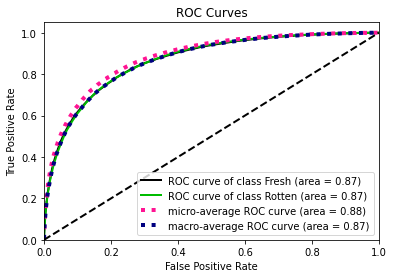

<Figure size 720x576 with 0 Axes>

In [204]:
skplt.metrics.plot_roc(y_test, y_proba_reglog)
plt.figure(figsize=(10,8))
plt.show()

In [205]:
pd.crosstab(y_test, y_reglog, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Fresh,Rotten,All
True,,,
Fresh,71894,8891,80785
Rotten,16757,28677,45434
All,88651,37568,126219


In [222]:
#save file with pickle
filename = "class_lemm_reglog.p"
pickle.dump( class_reglog, open( filename, "wb" ))

### Gradient Boosting

In [206]:
# XGBoost
from sklearn.ensemble import GradientBoostingClassifier

class_xgb = Pipeline([('tfidf', TfidfVectorizer()),
                    ('class', GradientBoostingClassifier())])

class_xgb.fit(X_train, y_train)
y_xgb = class_xgb.predict(X_test)
y_proba_xgb = class_xgb.predict_proba(X_test)

In [207]:
print(classification_report(y_test, y_xgb))

              precision    recall  f1-score   support

       Fresh       0.67      0.98      0.80     80785
      Rotten       0.79      0.14      0.24     45434

    accuracy                           0.68    126219
   macro avg       0.73      0.56      0.52    126219
weighted avg       0.71      0.68      0.60    126219



In [208]:
auc_xgb = roc_auc_score(y_test, y_proba_xgb[:,1])
print('AUC: %.3f' % auc_xgb)

AUC: 0.708


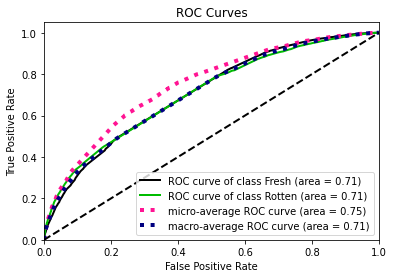

<Figure size 720x576 with 0 Axes>

In [209]:
skplt.metrics.plot_roc(y_test, y_proba_xgb)
plt.figure(figsize=(10,8))
plt.show()

In [210]:
pd.crosstab(y_test, y_xgb, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Fresh,Rotten,All
True,,,
Fresh,79051,1734,80785
Rotten,38943,6491,45434
All,117994,8225,126219


In [223]:
#save file with pickle
filename = "class_lemm_xgb.p"
pickle.dump( class_xgb, open( filename, "wb" ))

### SVC

In [211]:
# SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svm = LinearSVC()
clf = CalibratedClassifierCV(svm) 

class_svc = Pipeline([('tfidf', TfidfVectorizer()),
                    ('class', clf)])

class_svc.fit(X_train, y_train)
y_svc = class_svc.predict(X_test)
y_proba_svc = class_svc.predict_proba(X_test)

In [212]:
print(classification_report(y_test, y_svc))

              precision    recall  f1-score   support

       Fresh       0.81      0.88      0.85     80785
      Rotten       0.75      0.63      0.69     45434

    accuracy                           0.79    126219
   macro avg       0.78      0.76      0.77    126219
weighted avg       0.79      0.79      0.79    126219



In [213]:
auc_svc = roc_auc_score(y_test, y_proba_svc[:,1])
print('AUC: %.3f' % auc_svc)

AUC: 0.861


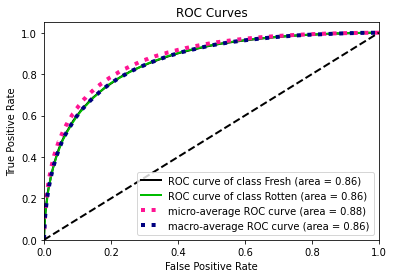

<Figure size 720x576 with 0 Axes>

In [214]:
skplt.metrics.plot_roc(y_test, y_proba_svc)
plt.figure(figsize=(10,8))
plt.show()

In [215]:
pd.crosstab(y_test, y_svc, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Fresh,Rotten,All
True,,,
Fresh,71318,9467,80785
Rotten,16598,28836,45434
All,87916,38303,126219


In [225]:
#save file with pickle
filename = "class_lemm_svc.p"
pickle.dump( class_svc, open( filename, "wb" ))

### KNN

In [216]:
from sklearn.neighbors import KNeighborsClassifier

class_knn = Pipeline([('tfidf', TfidfVectorizer()),
                    ('class', KNeighborsClassifier())])

class_knn.fit(X_train, y_train)
y_knn = class_knn.predict(X_test)
y_proba_knn = class_knn.predict_proba(X_test)

In [217]:
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

       Fresh       0.69      0.39      0.50     80785
      Rotten       0.39      0.69      0.50     45434

    accuracy                           0.50    126219
   macro avg       0.54      0.54      0.50    126219
weighted avg       0.58      0.50      0.50    126219



In [218]:
auc_knn = roc_auc_score(y_test, y_proba_knn[:,1])
print('AUC: %.3f' % auc_knn)

AUC: 0.554


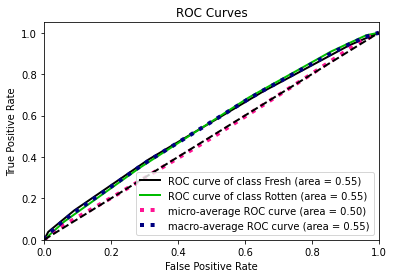

<Figure size 720x576 with 0 Axes>

In [219]:
skplt.metrics.plot_roc(y_test, y_proba_knn)
plt.figure(figsize=(10,8))
plt.show()

In [220]:
pd.crosstab(y_test, y_knn, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Fresh,Rotten,All
True,,,
Fresh,31356,49429,80785
Rotten,14201,31233,45434
All,45557,80662,126219


In [224]:
#save file with pickle
filename = "class_lemm_knn.p"
pickle.dump( class_knn, open( filename, "wb" ))

### Comparação dos Modelos

In [221]:
model_performance = [accuracy_score(y_test, y_svc),accuracy_score(y_test, y_reglog),accuracy_score(y_test, y_xgb),accuracy_score(y_test, y_knn)]
models = ['Linear SVC', 'Logistic Regression', 'XGBoost', 'KNN']
df_model = pd.DataFrame(model_performance, columns=['Accuracy'])
df_model['Model'] = models
df_model

,Accuracy,Model
0,0.793494,Linear SVC
1,0.796798,Logistic Regression
2,0.677727,XGBoost
3,0.495876,KNN


## Reviews dos usuários

In [230]:
import json
import requests
import re
import time
import string
from urllib.parse import urlparse


In [232]:
s = requests.Session()

In [258]:
def get_reviews(movie_url):
    r = requests.get(movie_url)
    movie_id = re.findall(r'(?<=movieId":")(.*)(?=","type)',r.text)[0]

    url = f"https://www.rottentomatoes.com/napi/movie/{movie_id}/reviews/user"
    
    headers = {
    'Referer': 'https://www.rottentomatoes.com/m/notebook/reviews?type=user',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36',
    'X-Requested-With': 'XMLHttpRequest',
        }
    
    payload = {
            'direction': 'next',
            'endCursor': '',
            'startCursor': '',
        }

    res = urlparse(movie_url)
    
    movie_link = []
    review_data = []

    while True:
            r = s.get(url, headers=headers, params=payload)
            data = r.json()

            if not data['pageInfo']['hasNextPage']:
                break

            payload['endCursor'] = data['pageInfo']['endCursor']
            payload['startCursor'] = data['pageInfo']['startCursor'] if data['pageInfo'].get('startCursor') else ''

            for index in range(0,len(data['reviews'])):
                movie_link.append(re.findall(r'(?<=\/)(.*?)(?=\/reviews)',res.path)[0])
                review_data.append(data['reviews'][index]['review'])

            time.sleep(1)

    movie = pd.DataFrame(
    {'rotten_tomatoes_link': movie_link, 'review_content': review_data}
        )
    
    return movie

In [259]:
movie = get_reviews('https://www.rottentomatoes.com/m/mother_2017/reviews')

In [260]:
movie.head()

,rotten_tomatoes_link,review_content
0,m/mother_2017,"An intense, gorgeous and brilliant allegory. I..."
1,m/mother_2017,too literal. lacks any kind of nuance. lacks c...
2,m/mother_2017,"As though as it is to watch and understand, it..."
3,m/mother_2017,This movie had me pissed off for 2 hours. Thou...
4,m/mother_2017,"Mother! Is frustrating, stupidly surrealistic ..."


In [261]:
movie.to_csv(os.path.join(files_path, "user_reviews_mother.csv"))

In [263]:
rt_reviews.loc[rt_reviews.rotten_tomatoes_link == 'm/mother_2017']['review_type'].value_counts()

Fresh     256
Rotten    118
Name: review_type, dtype: int64

<AxesSubplot:ylabel='review_type'>

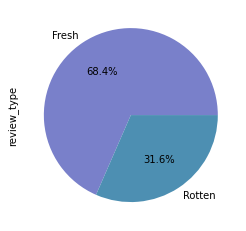

In [278]:
rt_reviews.loc[rt_reviews.rotten_tomatoes_link == 'm/mother_2017']['review_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [264]:
rt_reviews_strat.loc[rt_reviews_strat.rotten_tomatoes_link == 'm/mother_2017']['review_type'].value_counts()

Fresh     102
Rotten     47
Name: review_type, dtype: int64

In [283]:
rt_reviews_strat.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_year
658851,m/+_one_2019,James Berardinelli,True,ReelViews,Fresh,3/4,2019-06-12,"For romance junkies, the film checks all the b...",2019
658881,m/+_one_2019,Angie Han,False,Mashable,Fresh,NaN,2019-06-21,Therein lies the brilliance of Plus One: All o...,2019
658895,m/+_one_2019,Wendy Ide,False,Observer (UK),Fresh,4/5,2020-02-09,"Erskine, with her earthy chuckle and precision...",2020
658893,m/+_one_2019,Max Copeman,True,Little White Lies,Fresh,3/5,2020-02-06,A love story with its heart in the right place.,2020
658846,m/+_one_2019,Jesse Hassenger,True,AV Club,Fresh,B,2019-06-10,Plus One isn't much more than consistently amu...,2019


In [265]:
movie = lang_idf(movie)

In [267]:
movie.shape

(3678, 3)

In [270]:
movie = movie.loc[movie.lang_idf == 'en']

In [271]:
movie.shape

(3544, 4)

In [268]:
movie = prepare_text(movie)

In [272]:
movie.head(10)

,rotten_tomatoes_link,review_content,lang_idf,prepared_review_content
0,m/mother_2017,"An intense, gorgeous and brilliant allegory. I...",en,"intense , gorgeous brilliant allegory . little..."
1,m/mother_2017,too literal. lacks any kind of nuance. lacks c...,en,literal . lack kind nuance . lack creativity e...
2,m/mother_2017,"As though as it is to watch and understand, it...",en,"watch understand , brilliantly direct think ."
3,m/mother_2017,This movie had me pissed off for 2 hours. Thou...,en,movie piss 2 hour . thought ending massively g...
4,m/mother_2017,"Mother! Is frustrating, stupidly surrealistic ...",en,"mother ! frustrating , stupidly surrealistic d..."
6,m/mother_2017,The most remarkable thing about this film is J...,en,remarkable thing film Jennifer Lawrence perfor...
7,m/mother_2017,"This is very strange, confused me, in general ...",en,"strange , confuse , general know like ."
8,m/mother_2017,Everything in this movie is symbolic. You thin...,en,"movie symbolic . think go sense , . movie stre..."
9,m/mother_2017,"It is WILD ride, while also depressing.",en,"wild ride , depressing ."
10,m/mother_2017,Fuck it. They are playing with our emotions. W...,en,fuck . play emotion . bad movie see entire lif...


In [274]:
movie['class_pred'] = class_reglog.predict(movie['prepared_review_content'])

C:\Users\barbara.oliveira\AppData\Local\Temp\ipykernel_30292\1996527716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie['class_pred'] = class_reglog.predict(movie['prepared_review_content'])


In [276]:
movie.head(10)

,rotten_tomatoes_link,review_content,lang_idf,prepared_review_content,class_pred
0,m/mother_2017,"An intense, gorgeous and brilliant allegory. I...",en,"intense , gorgeous brilliant allegory . little...",Fresh
1,m/mother_2017,too literal. lacks any kind of nuance. lacks c...,en,literal . lack kind nuance . lack creativity e...,Rotten
2,m/mother_2017,"As though as it is to watch and understand, it...",en,"watch understand , brilliantly direct think .",Fresh
3,m/mother_2017,This movie had me pissed off for 2 hours. Thou...,en,movie piss 2 hour . thought ending massively g...,Rotten
4,m/mother_2017,"Mother! Is frustrating, stupidly surrealistic ...",en,"mother ! frustrating , stupidly surrealistic d...",Fresh
6,m/mother_2017,The most remarkable thing about this film is J...,en,remarkable thing film Jennifer Lawrence perfor...,Fresh
7,m/mother_2017,"This is very strange, confused me, in general ...",en,"strange , confuse , general know like .",Rotten
8,m/mother_2017,Everything in this movie is symbolic. You thin...,en,"movie symbolic . think go sense , . movie stre...",Rotten
9,m/mother_2017,"It is WILD ride, while also depressing.",en,"wild ride , depressing .",Fresh
10,m/mother_2017,Fuck it. They are playing with our emotions. W...,en,fuck . play emotion . bad movie see entire lif...,Rotten


In [277]:
movie.class_pred.value_counts()

Rotten    1941
Fresh     1603
Name: class_pred, dtype: int64

<AxesSubplot:ylabel='class_pred'>

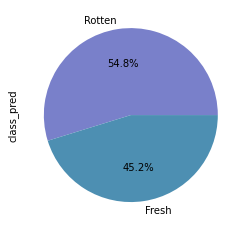

In [279]:
movie.class_pred.value_counts().plot(kind='pie', autopct='%1.1f%%')

In [335]:
movie.loc[movie.class_pred == "Rotten"][["review_content", "prepared_review_content"]].iloc[[37,1000,1002,1004]]

,review_content,prepared_review_content
69,I hated it. It was one of the worst horror mov...,"hate . bad horror movie watch , pointless , bo..."
2061,"Worst Movie Ever ! no plot, pretencious, try t...","bad Movie ! plot , pretencious , try deep end ..."
2067,Worst movie of all time. Almost tied with Noah...,bad movie time . tie Noah ... ending happen . ...
2070,Worst movie i ve ever seen! The end of Jennif...,bad movie ve see ! end Jennifer Lawrence car...


In [280]:
movie.to_csv(os.path.join(files_path, "user_reviews_mother_classified.csv"))